<a id="top"></a> 

# Basic Visualizations and Descriptive Statistics of Spike Train Data

<div class="question">
    
_**Synopsis**_ 

**Data:** Spontaneous spiking activity from a retinal neuron in culture, exposed to dark and light environments.


**Goals:** Visualize, compute and interpret descriptive and inferential statistics on spike trains.


**Tools:** firing rates, rastergrams, interspike interval (ISI) histograms, binned spike increments, fano factors (FF), autocorrelograms (AC), multiple comparisons corrections, analyses of variance (ANOVA), least significant differences (LSD), maximum likelihood estimations (MLE), Kolmogorov-Smirnov (KS) plots
</div>

* [Introduction](#Introduction)
* [Data Analysis](#DataAnalysis)
    1. [Spike Train Rastergrams](#Rasters)
    2. [Interspike Intervals](#ISIs)
    3. [Binned Spike Increments](#BSIs)
    4. [Autocorrelations of the Increments](#ACs)
    5. [Autocorrelations of the ISIs](#ACsOfISIs)
* [Summary](#Summary)
* [Appendix: Spike Count Mean and Variance for a Poisson Process](#Appendix)

<a id="Introduction"></a>
## Introduction

Neurons in the retina typically respond to patterns of light displayed over small sections of the visual field. However, when retinal neurons are grown in culture and held under constant light and environmental conditions, they will still spontaneously fire action potentials. In a fully functioning retina, this spontaneous activity is sometimes described as background firing activity, which is modulated as a function of visual stimuli. It is useful to understand the properties of this background activity in order to determine in future experiments how these firing properties are affected by specific stimuli.

### Case Study Data

A researcher examining the background firing properties of a culture-grown retinal neuron contacts us to discuss his data. He runs two experiments in which he records the spiking activity in two different states: one with the room lights off (dark condition) and the other with the room lights on (light condition). He would like to collaborate with us to determine whether there is a difference in background firing between these two conditions, and whether one environment is more conducive to future experimental analyses. He records the spiking activity as spike timestamps for 30 seconds in each condition.

### Goals

Typically the first step in any data analysis involves visualizing and using simple descriptive statistics to characterize pertinent features of the data. For time series data that takes on a value at each time point, like the field potentials analyzed in earlier chapters, we typically start by simply plotting each data value as a function of time. For spike train data, things can become a bit more complicated. One reason for this is that there are multiple equivalent ways to describe the same spike train data. The data could be stored as a sequence of spike times (rasters), as a sequence of waiting times between spikes (interspike intervals), or as the number of spikes in discrete time bins (binned spike increments). Knowing how to manipulate and visualize spike train data using all these different representations is the first step to understanding the structure presentin the data and is the primary goal of this chapter.

### Tools

We develop tools in this chapter to visualize spike train data and to provide basic statistical methods appropriate for analyzing spike trains.

<a id="DataAnalysis"></a>
       
## Data Analysis

Our data analysis begins with loading and describing the data.

In [1]:
## Set-up 

# Import required packages.
import scipy
import scipy.io as sio
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Set defaults for figure size, tight layout, and font size.
rcParams['figure.figsize'] = (12,6)
rcParams['figure.autolayout'] = True
rcParams.update({'font.size': 14})

C:\Users\Jai\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<div class="question">

**Q.** How can we extract the variables of interest from `data`? 
    
(*Hint*: The `sio.loadmat` function outputs a dict and the `keys` dict method returns the dict keys.)

</div>

In [2]:
## Load and print info on data

data = sio.loadmat('CH8-spikes-1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SpikesLow', 'SpikesHigh'])

There are two non-private keys in `data`:

`SpikesLow`: spike times over 30 s in the dark condition.

`SpikesHigh`: spike times over 30 s in the light condition.

<div class="question">

**Q.** How can we work with the data in the `SpikesLow` and `SpikesHigh` keys directly? 

Assign these keys to the variables `ts_dark` and `ts_light`. Ensure both of these variables are 1-d arrays.
    
</div>

In [3]:
## Flatten a numpy array to 1-d

ts_dark = data['SpikesLow'][0]  # this only works for 2-d arrays
ts_light = data['SpikesHigh'].reshape(-1)

Each variable is a single vector that gives a set of increasing spike times (aka timestamps, or 'ts') for the associated condition. The two vectors are of different sizes because the neuron fired a different number of spikes in each condition.

<div class="question">
    
**Q.** How do `len`, `shape`, and `size` differ in returning information about ndarrays?

</div>

In [4]:
## Use `len` `shape` and `size` on ndarrays

# The standard library function `len`, returns an int of the length of the first dimension.
print(len(ts_dark))
# Consider what would have happened had we not flattened our vector first:
print(len(data['SpikesLow']))

# The `shape` attribute is a tuple of the number of elements in each dimension.
print(ts_dark.shape)
# Consider what would have happened had we not flattened our vector first:
print(data['SpikesLow'].shape)

# The `size` attribute is an int of the total number of elements in the array.
print(ts_dark.size)
ts_dark.size == data['SpikesLow'].size == 750

750
1
(750,)
(1, 750)
750


True

<a id="Rasters"></a>
       
### Spike Train Rastergrams

Upon initial inspection of the data, we may be curious to see in which condition the firing rate for the neuron was higher. We can compute the firing rate ($f$), defined mathematically as

$$
f = \frac{n}{T},
\tag{1}
$$

where $n$ is the number of spikes over the time interval $T$.

<div class="question">
    
**Q.** How can we find the condition in which the neuron's firing rate was higher? 
    
Compute the firing rate of the neuron in each condition, and compare.
    
(*Hints*: Using the formula for $f$ above, $n$ can be found by getting the `size` attribute for the timestamp vectors for each condition, and $T$ can be found by subtracting the timestamp of the first spike from the timestamp of the last spike, for each condition, respectively.)
    
</div>

In [5]:
## Compute firing rates for neuron across both conditions

T_dark = ts_dark[-1] - ts_dark[0]
T_light = ts_light[-1] - ts_light[0]
n_dark = ts_dark.size
f_dark = n_dark / T_dark
n_light = ts_light.size
f_light = n_light / T_light

# Use `print(f'...')` to print formatted strings (round to 2 places past decimal).
print(f'f_dark = {f_dark:.2f}')
print(f'f_light = {f_light:.2f}')


f_dark = 25.04
f_light = 32.35


These calculations show us that the firing rate was higher in the light condition. Do the two datasets exhibit a statistically significant change in the firing structure between conditions? Or, does the difference in firing rates lie within the range of expected fluctuations between any two trials of random spiking data? To answer these types of questions, we need to develop statistical methods that are appropriate for analyzing spike trains. Let’s first look at the data more carefully and visualize the structure of the spiking in both conditions.

<div class="question">

**Q.** How can we visualize the data as a rastergram? 
    
Plot the spike times for the dark condition vs. a vector of zeros, and the spike times for the light condition vs. a vector of ones, on the same axes. Apply appropriate labels to the axes.
    
(*Hints*: Use `np.zeros` or `np.zeros_like` and `np.ones` or `np.ones_like` to create a vector of zeros and ones. Create a figure and axes using `plt.subplots`. Use the axes `plot` method to plot the timestamps vs. the vectors of zeros or ones. Set the `marker` and `linestyle` keyword input arguments to `plot` to appropriately visualize the raster as dots.) 

</div>

Text(0.5, 1.0, 'Spike Rasters for Same Neuron Across Light Conditions')

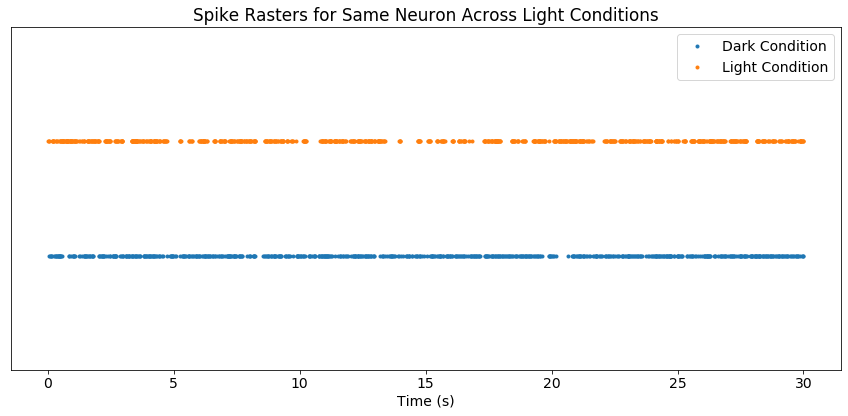

In [6]:
## Plot rastergrams of spike trains for both conditions

# Create a figure.
fig1, ax1 = plt.subplots()
# Plot timestamps vs. zeros for dark condition (*Note, it is good practice to set
# optional input args via keywords, like with `marker='.'` and `linestyle=''` below).
ax1.plot(ts_dark, np.zeros_like(ts_dark), marker='.', linestyle='')
# Plot timestamps vs. ones for light condition.
ax1.plot(ts_light, np.ones_like(ts_light), marker='.', linestyle='')
ax1.set_xlabel('Time (s)')
# Zoom out on y axis and hide y ticks.
ax1.set_ylim([-1, 2])
ax1.set_yticks([])
# Add legend and title.
ax1.legend(['Dark Condition', 'Light Condition'])
ax1.set_title('Spike Rasters for Same Neuron Across Light Conditions')

With the data visualized in this way, we’re now able to ask an interesting question: What structure do we notice in the two spike trains? At first glance, our answer might be “not much.” Spikes occur fairly regularly throughout the 30 s interval under both conditions. At this scale, it may even look like there are more spikes in the dark than in the light condition, even though we know the opposite is true.

The spike times themselves do not seem to be directly comparable between these conditions. Often, when we examine data from a stimulus response experiment, we expect to see regions where spiking activity increases or decreases as a function of a *changing* stimulus. In this case, the stimulus (the ambient light level) remains constant over both experiments, respectively. How else can we analyze these data and identify differences in the spiking activity (if any) between the two conditions?

So far, we have examined the long-term structure of the spiking. Let’s now focus on a shorter-term structure that occurs within a single second or less.

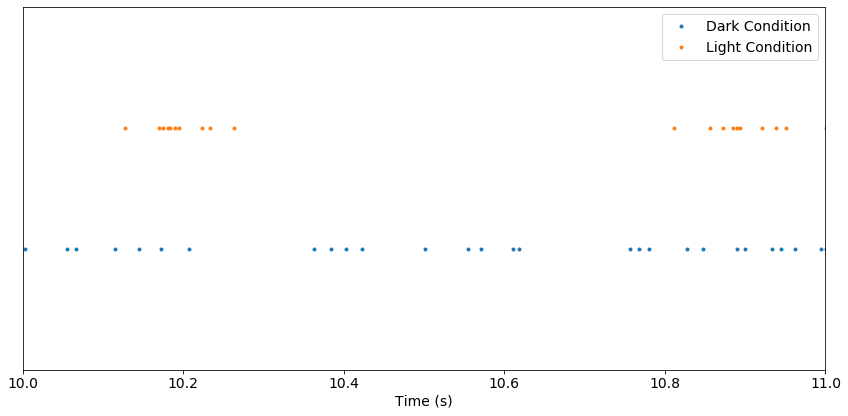

In [7]:
## Plot rasters to show one second of data for both conditions from T = 10-11 s

fig2, ax2 = plt.subplots()
# Plot rasters and add a label for each raster.
raster_dark = ax2.plot(ts_dark, np.zeros_like(ts_dark), 
                       marker='.', linestyle='', label='Dark Condition')
raster_light = ax2.plot(ts_light, np.ones_like(ts_light), 
                        marker='.', linestyle='', label='Light Condition')
# Set axes and axes labels for dark and light conditions.
ax2.set_xlim([10, 11])              
ax2.set_ylim([-1, 2])
ax2.set_yticks([])
ax2.set_xlabel('Time (s)')
# Since we set labels for our plots, we can call the `legend` method without
# specifying the input args, and it will use the labels for the rasters.
ax2.legend()

The code above was essentially copied and pasted from the previous section with a couple minor updates to change the time interval and the way we create the legend. It is generally poor practice to repeat a lot of similar calculations in such a manner; if we needed to do so, we should create a function instead.

<div class="question">

**Q.**: How can we visualize spike train rasters for different conditions and different time ranges without continuously copying and pasting code? 
    
Create a function, `plot_rasters`, that takes 2 inputs: an ndarray matrix of spikes, `spks` (where each row is a different spike train and each column represents a spike timestamp (in s)), and a time range, `t` (a vector of 2 numbers: the start and end of the range (in s)). `plot_rasters` should create a figure which displays a raster for each spike train in `spks` on the same axes, with each spike train offset on the y axis. `plot_rasters` should return 3 outputs: the figure, `fig`, axes, `ax`, and rasters, `rasters`, which the function creates. 
    
(*Hints*: Most of the code above in this section can be slightly adjusted to be used in the function body. Use a comprehension to generate a raster for each spike train.)

</div>

In [8]:
def plot_rasters(spks, t):
    """
    Plots rasters for each row of spike trains in `spks` within the time interval `t`.
    
    Parameters:
    -----------
        spks (ndarray): a 2-d matrix of spike train timestamp vectors (# of spike trains X 
                        # of timestamps) (in s)
        t (ndarray | list | tuple): two numbers specifying a time range (in s)
    
    Returns:
    --------
        fig(figure): a handle to the figure that holds the created rasters
        ax(axes): a handle to the plot that holds the created rasters
        rasters(lines): a handle to the rasters plotted on `ax`
    """
    
    # Get the number of spike trains.
    n_trains = len(spks)
    # Create the figure.
    fig, ax = plt.subplots()
    # Plot the spike trains using a comprehension.
    rasters = [ax.plot(spks[train], np.zeros_like(spks[train])+train, marker='.', linestyle='') \
               for train in range(0,n_trains)]
    # Set xlim according to `t` and label x axis.
    ax.set_xlim([t[0], t[1]])
    ax.set_xlabel('Time (s)')
    # Zoom out an y axis and hide y ticks.
    ax.set_ylim([-1, n_trains+1])
    ax.set_yticks([])
    return fig, ax, rasters

<div class="question">

**Q:** How can we use and test `plot_rasters`? 
    
Use `plot_rasters` to create a similar figure to the one above: show the spike times for both conditions in the interval from 10-11 s. Create a test to show that, for both conditions in the above interval, the number of datapoints in the plots for both rasters is equal to the number of datapoints in the spike times vectors.

(*Hints:* Pad `ts_dark` with nans so the new vector has length equal to `ts_light`, and then vertically concatenate the two vectors into a single ndarray (see `np.pad`, `np.nan`, and `np.vstack`) to feed into `plot_rasters`. Use `assert` to create the test: use the `get_ydata` method on the returned rasters output to get the plotted points, and `size` to get the number of datapoints from both the rasterplots and spike times vectors.) 
    
</div>

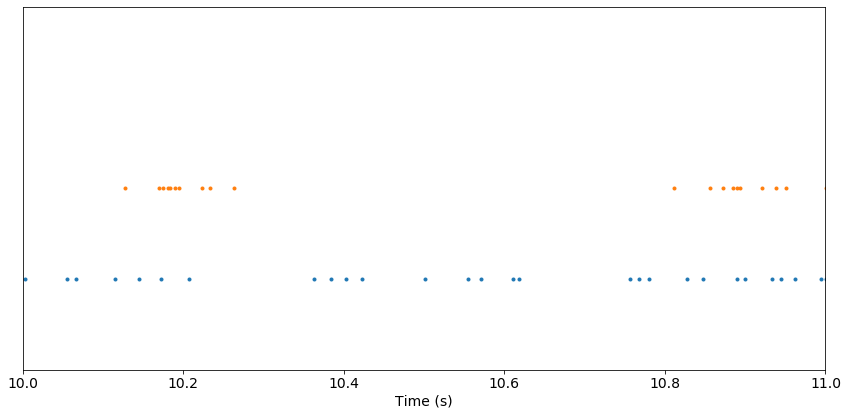

In [9]:
## Use `plot_rasters` to generate rasters for both conditions for the interval 10-11s,
## and create an appropriate test for the function

# Pad the `ts_dark` vector with nans to match lengths with `ts_light`.
ts_dark_padded = np.pad(ts_dark, pad_width = (0, (len(ts_light)-len(ts_dark))), \
                        mode = 'constant', constant_values = np.NaN)

# Concatenate vectors vertically.
# (We have to use double parentheses because `np.vstack` only takes a single ndarray-like
# argument, so first we combine 'ts_dark_padded' and `ts_light` into a tuple - we could have
# also combined them into a list. This is a common theme for many numpy operations on ndarrays.)
spks = np.vstack((ts_dark_padded, ts_light))

# Run function:

t = [10,11] # set time interval
fig, ax, rasters = plot_rasters(spks,t)

# Run test:

# Get individual rasters for dark and light conditions.
r_dark = rasters[0][0]
r_light = rasters[1][0]
# `assert` that the number of points plotted matches the number of timestamps for each condition.
assert r_light.get_ydata().size == ts_light.size and r_dark.get_ydata().size == ts_light.size

# Note that `r_dark.get_ydata().size == ts_light.size` because we ran the function 
# on `ts_dark_padded`, not `ts_dark`.

<div class="question">

**Q:** How can we create a function that behaves the same as `plot_rasters`, but takes in an arbitrary number of input arguments, where these arguments are vectors of spike times (in s) for spike trains which could be of different sizes (instead of the single spike train matrix required by `plot_rasters`)?
    
Create a function, `plot_rasters2`, that takes as inputs an arbitrary number of individual spike train vectors (e.g. `[train1, train2,...trainN]`), and a time range, `t`, equivalent to `t` in `plot_rasters`. `plot_rasters2` should return the same outputs as `plot_rasters`. 

(*Hints:* we can use `plot_rasters` as a template and replace the `spks` input arg with `*args` as an input arg to gather the arbitrary number of individual spike train vectors. Note, when using `*args` to gather an arbitrary number of input args, `*args` must come last in the function definition.)
    
</div>

In [10]:
def plot_rasters2(t, *args):
    """ 
    Plots rasters for each spike train timestamp vector in `*args*` within the time interval `t`
    
    Parameters:
    -----------
        *args (ndarray | list | tuple): spike train timestamp vectors (in s) with 
                                        length == # of timestamps 
        t (ndarray | list | tuple): two numbers specifying a time range (in s)
    
    Returns:
    --------
        fig(figure): a handle to the figure that holds the created rasters
        ax(axes): a handle to the plot that holds the created rasters
        rasters(lines): a handle to the rasters plotted on `ax`
    """
    
    # Create the figure.
    fig, ax = plt.subplots()
    # Plot the spike trains using a comprehension.
    rasters = [ax.plot(args[a], np.zeros_like(args[a])+a, marker='.', linestyle='') \
               for a in range(0, len(args))]
    # Set xlim according to `t` and label x axis.
    ax.set_xlim([t[0], t[1]])
    ax.set_xlabel('Time (s)')
    # Zoom out an y axis and hide y ticks.
    ax.set_ylim([-1, len(args)+1])
    ax.set_yticks([])
    return fig, ax, rasters

<div class="question">

**Q:** How can we test and use `plot_rasters2`? 
    
Use `plot_rasters2` to create an identical copy of the figure we created via `plot_rasters`: show the spike times for both conditions in the interval from 10-11 s. Create a test for `plot_rasters2` that has the same expected behavior as the test created for `plot_rasters`: show that, for both conditions in the above interval, the number of datapoints in the plots for both rasters is equal to the number of datapoints in the spike times vectors.
    
</div>

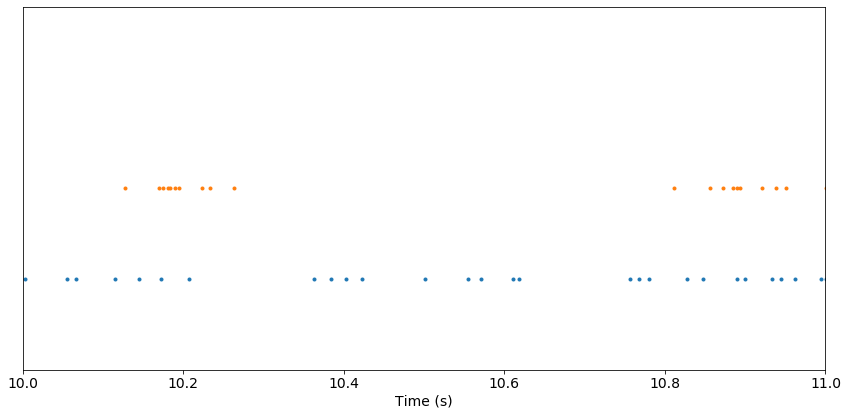

In [11]:
## Use `plot_rasters2` to generate rasters for both conditions for the interval 10-11s,
## and create an appropriate test for the function

# Run function:

t = [10,11]
fig, ax, rasters = plot_rasters2(t, ts_dark, ts_light)

# Run test:

# Get individual rasters for dark and light conditions.
r_dark = rasters[0][0]
r_light = rasters[1][0]

# `assert` that the number of points plotted matches the number of timestamps for each condition.
assert r_light.get_ydata().size == ts_light.size and r_dark.get_ydata().size == ts_dark.size

# Note that now `r_dark.get_ydata().size == ts_dark.size` (as opposed to the case in 
# `plot_rasters`) because we didn't have to pad `ts_dark` for `plot_rasters2`.

Inspecting smaller time intervals, we might notice bursts of spikes that cluster near each other in time, interspersed with longer periods that contain less spiking. These patterns of bursts and quiescence look different between the dark and light conditions. Visual inspection is an important tool, but we would like a quantitative result. How might we compare this fine temporal structure in the two conditions?

[Back to top](#top)

<a id="ISIs"></a>
### Interspike Intervals

One approach to further characterize the differences in spiking between the two conditions is to transform the data. One of the most useful transformations focuses on the waiting times between the spikes, or interspike intervals (ISIs), instead of the spike times themselves. 

<div class="question">

**Q:** What is another way in which we could compare the spike trains across the two conditions? 
    
Compute the ISIs, and for a first visualization, simply plot the ISI vectors for both conditions. Create a 1x2 subplot, where `isi_dark` is plotted on the left subplot in blue, and `isi_light` is plotted on the right subplot in red. Share the x and y axes for both figures, and set the axes ylim to be the maximum ISI time for either condition. Appropriately label both subplots.

(*Hints*: Use `np.diff` to compute the ISIs. Use `plt.subplots` to create and set the subplots. `plt.subplots` should take 4 inputs: the keyword arguments `nrows`, `ncols`, `sharex`, and `sharey`. Use `np.max` to set the axes ylim. `np.max` should take 1 input :the concatenated array (see `np.hstack`) of `isi_light` and `isi_dark` to get the max y value. Use the axes `plot` method to create one plot for each axes. `plot` should take 2 inputs: an ISI vector and the keyword argument `color`.)

</div>

Text(0.5, 1.0, 'ISIs Light Condition')

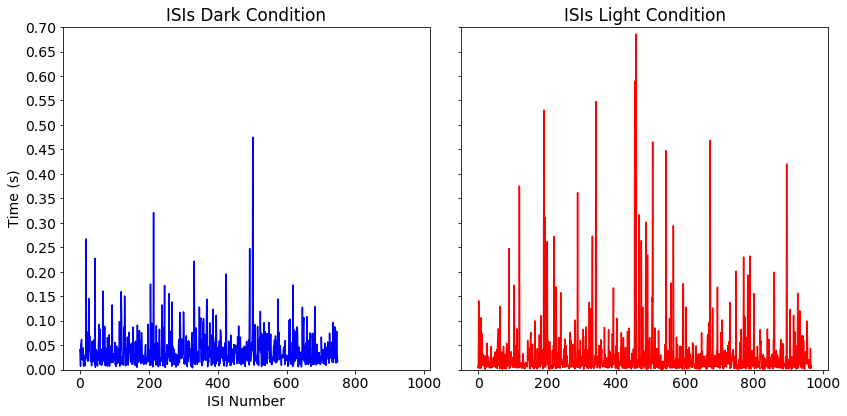

In [12]:
## Compute and plot the ISIs for the dark and light conditions

# Compute ISIs.
isi_dark = np.diff(ts_dark)    
isi_light = np.diff(ts_light)  

# Create 2 subplots with shared axes.
fig3, ax3 = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
# Plot the ISIs and label the axes.
ax3[0].plot(isi_dark, color='b')
ax3[1].plot(isi_light, color='r')
ax3[0].set_xlabel('ISI Number')
ax3[0].set_ylabel('Time (s)')
# Set `ylim` as max ISI for either condition.
ylim = np.max(np.hstack((isi_dark, isi_light)))
# Increase the yticks to show every 0.05s from 0-`ylim+0.05`.
ax3[1].set_yticks(np.arange(0,ylim+0.05,0.05))
# Set the axes ylim from 0-`ylim+0.05`.
ax3[1].set_ylim([0, ax3[1].get_yticks()[-1]])
# Set titles.
ax3[0].set_title('ISIs Dark Condition')
ax3[1].set_title('ISIs Light Condition')

We see that the ISI values range from small times (less than 0.05 s) to large times (over 0.65 s). In this way, the visualization provides some insight into how the ISI values differ across the conditions.

Plots of the ISI vectors provide some information about the data (e.g., the approximate range of the ISI values), but there’s more insight to be gained.

<div class="question">

**Q:** How can we visualize the ISIs in another way? 
    
Plot histograms for both sets of ISIs, again using 2 subplots with the color and axes scheme we used above. Use 1 ms bins from 0-100 ms. Appropriately label both subplots.

(*Hints*: Use `np.arange` to set the bins (in ms). Use the axes `hist` method that takes as inputs the ISI vectors (converted to ms) and the vector of bins to create one histogram for each axes.)
    
</div>

Text(0.5, 1.0, 'ISIs Light Condition')

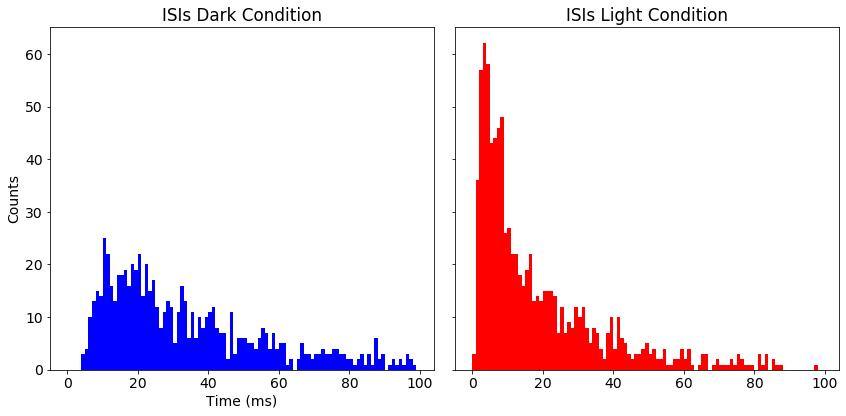

In [13]:
## Plot the ISI histograms for both conditions

# Create 2 subplots with shared axes and increase the figure size.
fig4, ax4 = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,6))
# Set the bins in ms.
bins = np.arange(0, 100, 1) # in ms
# Create and label the histograms.
ax4[0].hist(isi_dark*1000, bins, color='b') # in ms
ax4[1].hist(isi_light*1000, bins, color='r') # in ms
ax4[0].set_xlabel('Time (ms)')
ax4[0].set_ylabel('Counts')
ax4[0].set_title('ISIs Dark Condition')
ax4[1].set_title('ISIs Light Condition')

In the ISI histogram of the dark condition, very few counts occur at small ISI values (near 0 ms) and high ISI values (above 80 ms). Instead, the distribution of counts is broadly peaked in the approximate interval 5–20 ms.

What does the ISI distribution reveal about the spiking activity in the dark condition? We could conclude from the ISI distribution that many spikes are separated by time intervals 5–20 ms. So, we might be tempted to imagine near-periodic spiking with a period 5–20 ms:

<a id="fig:8.6a"></a>

![Cartoon representation of spiking activity.](imgs/8-6a.png "Near-periodic spiking, with period 5&mdash;20 ms.")

However, the histogram contains additional structure beyond the single broad peak. Indeed, the histogram has a long tail. Therefore, the intervals between spikes are varied. We often see ISIs in the 5–20 ms interval, but we also find much longer ISIs. The structure of the ISI histogram is consistent with bursting activity, which consists of intervals of rapid spiking interspersed with quiescence:

<a id="fig:8.6b"></a>

![Cartoon representation of spiking activity.](imgs/8-6b.png "Bursting activity, with both short and long intervals between spikes.")

The intervals of rapid spiking produce many shorter ISIs, and the longer intervals produce (typically fewer) longer ISIs. We may conceptualize a bursting neuron as having two time scales: fast and slow. From the shape of the histogram of the dark condition, we could conclude that the spike train data in the dark condition are more consistent with bursting activity than with periodic, metronome-like spiking activity. We could conclude that this is also the case in the light condition. We could claim that the neuron exhibits bursting activity in both conditions, but clearly there are some difference between the two ISI histograms: consider the impact of the large proportion of small ISIs in the light condition. We'll continue on to examine this further.
    


</div>

<a id="BSIs"></a>
### Examining Binned Spike Increments

Another common approach to analyzing spiking data is to discretize time into bins of fixed width, and count the number of events that occur in each time bin. This differs from the ISI histogram above, because in this case we will not look at the time between events, but the number of events themselves. The sequence of spike counts across the bins is sometimes called the *increment process* for a spike train. When the time bins are sufficiently small, say, 1 ms for typical spike train data, the resulting increment process is just a sequence of zeros and ones. In this case, the time bins are so small that the probability of more than one spike occurring in each bin is virtually zero. Each tiny time bin then contains a spike (and we assign that bin a value of 1) or does not (and we assign that bin a value of 0). This idea of representing the spike train as a sequence of zeros and ones for small bin increments will be important later when we build statistical models of the spike trains.

<div class="question">

**Q:** How can we visualize the amount of variability in the spike trains for both conditions? 
    
Compute and plot the increment process for the entire spike train for both conditions in time bins of 50 ms for the time interval 0-30s, again using 2 subplots with the color and axes scheme we used above. Appropriately label both subplots. 
    
(*Hints*: Use `np.arange` to set the bins from a start time, stop time, and bin width. Use `np.histogram` to compute the increment process from the spike times and the bins. Use the axes `bar` method on the computed bins and increments to create a bar plot for each axes.)
    
</div>

Text(0.5, 1.0, 'Increment Process Light Condition')

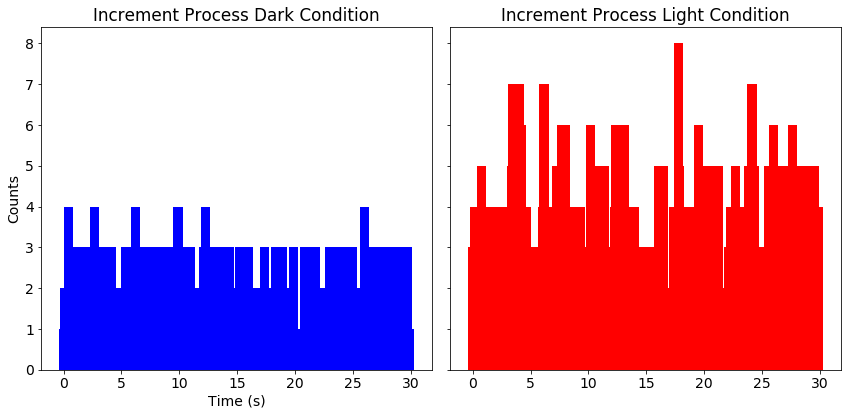

In [14]:
## Compute the increment process for both conditions

# Set the bins
bin_length = 0.050 # 50 ms
bins = np.arange(0, 30, bin_length)

# Compute the increments (only return the first output argument, the histogram; 
# we don't need the second, the bin edges).
increment_dark_50, _ = np.histogram(ts_dark, bins)
# this is the preferred way to return a single output from a multi-output function call:
# see: https://stackoverflow.com/questions/431866/ignore-python-multiple-return-value
increment_light_50  = np.histogram(ts_light, bins)[0]

# Create a bar plot of the increments.
fig5, ax5 = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,6))
# Exclude the last element in `bins` when plotting, so the number of elements
# matches the number of elements of the increments.
ax5[0].bar(bins[:-1], increment_dark_50, color='b')
ax5[1].bar(bins[:-1], increment_light_50, color='r')
ax5[0].set_xlabel('Time (s)')
ax5[0].set_ylabel('Counts')
ax5[0].set_title('Increment Process Dark Condition')
ax5[1].set_title('Increment Process Light Condition')

One question that arises quite often is how variable these binned counts are. To illustrate this variability, let’s consider two scenarios. In the first, consider a neuron that fires perfectly regularly, like a metronome. In this case, we expect the number of spikes in each time bin to be identical. On the other hand, consider the scenario of a neuron that fires in irregular bursts. In this case, we expect much more variability in the number of spikes in each time bin, depending on whether a time bin contained a burst of spikes or a quiet period. To characterize this variability, a standard measure to compute is the sample *Fano factor (FF)*. It’s easy to define the Fano factor: *FF is the sample variance of the increment process divided by the sample mean of the increment process*. This is very similar to the *coefficient of variation (CV)*, which is *the sample standard deviation divided by the sample mean*.

<div class="question">

**Q:** How can we quantify the amount of variability in the spike trains for both conditions? 
    
compute the FF from the increments computed above for both conditions, and appropriately assign the results to the variables `ff_dark_50` and `ff_light_50`, respectively.
    
(*Hints*: Use the `var` and `mean` methods for ndarrays)
    
</div>

In [15]:
## compute the FF for both conditions

ff_dark_50 = increment_dark_50.var() / increment_dark_50.mean()
ff_light_50 = increment_light_50.var() / increment_light_50.mean()

print(f'ff_dark_50 = {ff_dark_50:.2f}')
print(f'ff_light_50 = {ff_light_50:.2f}')

ff_dark_50 = 0.72
ff_light_50 = 1.78


To interpret this FF, we need to introduce the concept of a Poisson process. A Poisson process is a model for a spiking process for which each spike occurrence is independent of every other spike occurrence. In other words, the probability of a neuron spiking at any instant does not depend on when the neuron fired (or did not fire) previously.

The Poisson process is rarely an accurate model for spike train data. Our biological knowledge reveals that the occurrence of a spike *does* depend on the occurrence of previous spikes (e.g. when we take into account the refractory period, and phenomena like bursting). However, the Poisson process has many nice theoretical properties that make it a good model against which to compare the data. For example, for any Poisson process, the number of spikes in any time interval has a Poisson probability distribution for which the theoretical variance and mean are equal (see the [appendix](#appendix) at the end of the chapter). Therefore, the theoretical Fano factor for a Poisson process is exactly equal to 1.

When measuring the variability of the increments of a spike train, we typically compare it to the variability of a Poisson process. If we compute a FF well below the value 1 for a particular set of increments, this suggests that the spiking is more regular than a Poisson process for the time scale at which the increments were binned. In this case, spiking activity in the past is influencing the neuron to spike in a more predictable manner in subsequent bins. If we compute a FF well above the value 1, this suggests that the spiking is more variable than a Poisson process for the time scale at which the increments were binned.

Based on this and our calculations of the FF for both conditions, we could conclude that the spiking in the dark condition is more regular, and the spiking in the light condition more variable, than a Poisson process.

#### Does the observed Fano factor differ from 1?

The preceding results are somewhat unsatisfying. We claimed that in the dark condition, because the FF was 0.72, spiking is more regular than a Poisson process. What if, instead, we computed a FF of 0.8; is that well enough below 1 for the spiking to be considered more regular than a Poisson process? Is a FF of 0.9 well enough below 1? These questions highlight an important issue when drawing a conclusion from a FF: How far above or below the value of 1 does the computed FF have to be before we are confident that there is really a statistically significant difference in the variability from a Poisson process (i.e. that the computed FF is not coming from a Poisson distribution)? After all, even if we had spiking from a true Poisson process, from one experiment to the next we would expect to find different values for the increments, and values for the sample FF that fluctuate slightly above and below 1. 

Fortunately, a bit of statistical theory can help us out. It can be shown that the distribution of Fano factors that we might compute from a Poisson process follows a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) with shape parameter $(N - 1)/2$ and scale parameter
$2/(N - 1)$, where $N$ is the number of time bins used in the Fano factor calculation [[Eden & Kramer, 2010](https://doi.org/10.1016/j.jneumeth.2010.04.012)].




<div class="question">

**Q:** How can we visualize a distribution of theoretical Fano factors based on our increments? 
    
Compute and plot the pdf of the gamma distribution with shape parameter $(N - 1)/2$ and scale parameter $2/(N - 1)$ where $N$ is equal to the number of bins we used to compute our increments. Set the x-axis to have 1000 values evenly sampled between 0.5 and 1.5 (this will create a smooth plot for the pdf). Appropriately label the plot.

(*Hints*: Use `np.linspace` to create the values for the x-axes, and `stats.gamma.pdf` to create the gamma distribution pdf. `stats.gamma.pdf` takes as inputs the values for the x-axes, the shape parameter, and the scale parameter. Then use the axes `plot` method to plot the pdf for the values of the x-axes.)

</div>

Text(0.5, 1.0, 'PDF')

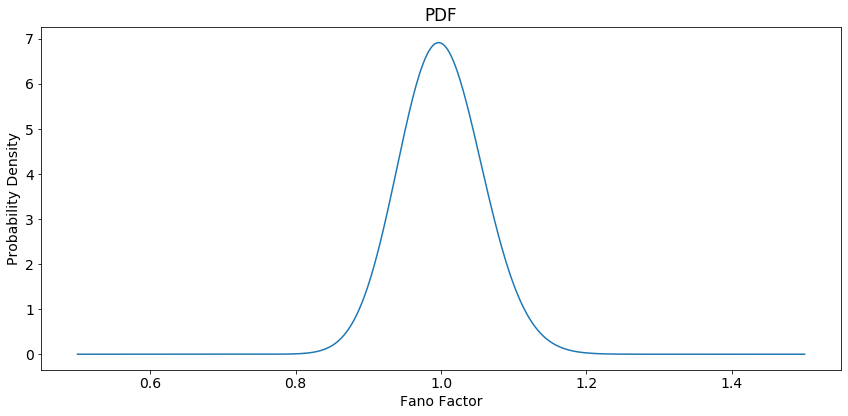

In [16]:
## Plot the gamma distribution pdf

# Create x-axis values.
xax_vals = np.linspace(.5, 1.5, 1000)

# Compute the shape and scale parameters, and create the gamma pdf.
N = bins.size;
shape = (N-1) / 2             
scale = 2 / (N-1)
y_pdf = stats.gamma.pdf(xax_vals, shape, scale=scale)

# Plot the pdf.
fig6, ax6 = plt.subplots()
ax6.plot(xax_vals, y_pdf)
ax6.set_xlabel('Fano Factor')
ax6.set_ylabel('Probability Density')
ax6.set_title('PDF')


When $N$ is large, as it is here, the gamma pdf looks like a normal distribution (i.e., like a bell-shaped curve). We can use this distribution to construct an interval where we would expect the Fano factor to lie if the data were generated by a Poisson process. More specifically, if the data were generated by a Poisson process, then we would expect the Fano factor to lie in the 95% confidence interval around the value of 1. 

<div class="question">

**Q:** How can we see if our computed FFs for both conditions differ significantly from our theoretical gamma distribution of FFs? 
    
Compute the 95% confidence interval for our theoretical gamma distribution, and add the lower and upper bounds as red, vertical lines to the pdf plot. For both conditions, compute the probability that the computed FF is in the theoretical gamma distribution. 

(*Hints*: Use `stats.gamma.ppf` to compute the confidence interval. `stats.gamma.ppf` should take 3 inputs: an array with 2 numbers (the lower and upper bound of the confidence interval), the distribution shape parameter, and the keyword argument `scale` set to the distribution scale parameter. Use the axes `vlines` method to add the lower and upper bounds to the pdf plot. Use `stats.gammma.cdf` to compute the probability that the computed FF for both conditions is in the theoretical gamma distribution (assume a lower-tail one-tail test for the dark condition, and an upper-tail one-tail test for the light condition. `stats.gamma.cdf` should take 3 inputs: the computed FF, the distribution shape parameter, and the keyword argument `scale` set to the distribution scale parameter.)
    
</div>

The 95% confidence interval is between 0.890 and 1.116

The percentage of values in our theoretical gamma distribution that are less than or equal to our computed FF for the dark condition is 0.00000

The percentage of values in our theoretical gamma distribution that are greater than or equal to our computed FF for the light condition is 0.00000


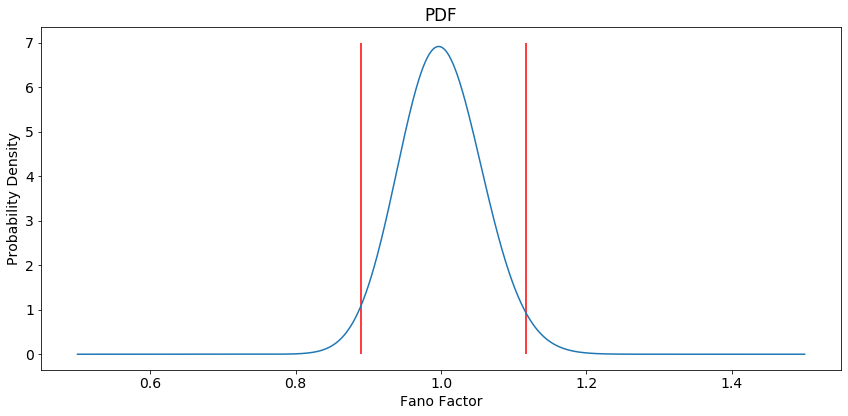

In [17]:
## compute 95% confidence intervals for the gamma distribution of FF factors
## and add the bounds as vertical lines to the pdf plot. Then compute one-tailed p-values for
## the probability that the computed FFs for each condition belong to the gamma distribution.

# compute and plot 95% confidence intervals:

ci_95 = stats.gamma.ppf([.025, .975], shape, scale=scale)
print('The 95% confidence interval is between {:.3f} and {:.3f}'.format(ci_95[0], ci_95[1]))
ax6.vlines(ci_95[0], ymin=0, ymax=7, color='r')
ax6.vlines(ci_95[1], ymin=0, ymax=7, color='r')

# compute probability of finding our computed FF for dark and light conditions within theoretical
# gamma distribution:

p_ff_dark = stats.gamma.cdf(ff_dark_50, shape, scale=scale) # cdf from lower bound to `ff_dark_50`
p_ff_light = 1 - stats.gamma.cdf(ff_light_50, shape, scale=scale) # cdf from`ff_light_50` to upper bound

# Print our interpretations of the `p_ff_dark` and `p_ff_light` (rounded to 5 places past decimal).
print('\nThe percentage of values in our theoretical gamma distribution that are ' \
      'less than or equal to our computed FF for the dark condition is ' \
      '{:.5f}'.format(p_ff_dark))
      
print('\nThe percentage of values in our theoretical gamma distribution that are ' \
      'greater than or equal to our computed FF for the light condition is ' \
      '{:.5f}'.format(p_ff_light))

# Show figure.
fig6

Visually, we can see that our computed FF values for the dark condition and light condition lie well below and above the lower and upper bounds for the 95% confidence interval, respectively. Our computed p-values confirm this. We can therefore reject the hypothesis that the spike trains in either condition were generated by a Poisson process.

Remember, however, that our FF is dependent on the way we compute our increments (specifically, the number of bins we use).

<div class="question">

**Q.** How can we see if the results for the Fano factor change in each condition with different choices for the bin size of the increment process (e.g., 25 ms, 100 ms, 500 ms)? 

Create a function, `compute_ff` that takes 4 inputs: `spk_train`, a spike times vector (in s), `t`, two numbers specifying a time range (in s), `binwidth`, a desired binwidth (in s),  and `cl`, a conifdence level (in the interval (0,1) ) for which to return the lower and upper bounds of the related confidence interval. `compute_ff` should return 3 outputs: `ff`, the FF for the spike train for the given binwidth and time interval, `ci`, a two-element vector with the lower and upper bounds of the `cl`% confidence interval for the theoertical gamma distribution created from the binwidth, `p`, the percentage of values in the theoretical gamma distribution that are less than or equal to `ff` (if `ff` < 1), or greater than or equal to `ff` (if `ff` > 1).

(*Hints*: Most of the code above in this section can be slightly adjusted to be used in the function body. For coding the function body:

- Compute the increment for the spikes in the given time range. 
- Next, compute the FF from the increment. 
- Next, create the theoretical gamma distribution from the binwidth. 
- Next, compute the confidence interval bounds from the confidence level. 
- Last, compute the p-value.   
    
</div>

In [18]:
def compute_ff(spk_train, t, binwidth, cl=0.95):
    """ 
    Returns the Fano Factor (FF) for a given spike train and binwidth (both in ms). Also returns 
    the confidence interval bounds for a given confidence level, a p-value that indicates how 
    likely it is that the computed Fano Factor would be in a theoretical gamma distribution  
    created from the binwidth, and a figure that shows the pdf of the theoretical gamma
    distribution and the confidence interval bounds.
    
    Parameters:
    -----------
        spk_train (ndarray | list | tuple): a vector of spike train timestamps (in s)
        t (ndarray | list | tuple): two numbers specifying a time range (in s)
        binwidth (int): a desired binwidth (in s)
        cl (numeric): a conifdence level (in the interval (0,1)) for which to return the lower 
                      and upper bounds of the related confidence interval (default = 0.95)
    
    Returns:
    --------
        ff (float): the Fano Factor for `spk_train` and `bin`
        ci (ndarray): the confidence interval bounds for `cl`
        p (float): the percentage of values in the theoretical gamma distribution that are less
                       than or equal to ff (if ff < 1), or greater than or equal to ff (if ff > 1)
    """
       
    # Ensure `spk_train` is ndarray, and only get values within `time_interval`.
    spk_train = np.asarray(spk_train) # convert to ndarray for `np.where`
    spk_train = spk_train[np.where((spk_train>=0) & (spk_train<=30))]
    
    # Compute increment.
    bins = np.arange(t[0], t[1], binwidth)
    increment, _ = np.histogram(spk_train, bins)

    # Compute FF.
    ff = increment.var() / increment.mean()
    
    # Create gamma distribution.
    xax_vals = np.linspace(.5, 1.5, 1000) # x axis values for gamma pdf
    N = bins.size;
    shape = (N-1) / 2 # shape parameter for gamma distribution based on `bin`    
    scale = 2 / (N-1) # scale parameter for gamma distribution based on `bin`
    y_pdf = stats.gamma.pdf(xax_vals, shape, scale=scale) # gamma pdf
    
    # Compute confidence interval.
    ci_lower = (1-cl)/2
    ci_upper = cl + (1-cl)/2
    ci = stats.gamma.ppf([ci_lower, ci_upper], shape, scale=scale)
    
    # Compute p-value for FF.
    if ff <= 1:
        p = stats.gamma.cdf(ff, shape, scale=scale)
    else:
        p = 1 - stats.gamma.cdf(ff, shape, scale=scale)
        
    return ff, ci, p    

<div class="question">

**Q:** How can we test and use `compute_ff`? 

Run `compute_ff` on the spike train for the light condition, with a binwidth of 50 ms, for the time range [0-30s], and use `assert` to test that the returned `ff` is equal to `ff_light_50`, that `ci` is equal to `ci_95`, and that `p` is equal to `p_ff_light`. Plot a figure containing the pdf of the theoretical gamma distribution with red vertical lines indicating the lower and upper bounds of the 95% confidence interval.
    
(*Hint*: Use `np.all` to ensure both elements in `ci` are equal to both elements in `ci_95`, respectively.)
    
</div>

In [19]:
## Use `compute_ff` on `ts_light` with a binwidth of 50 ms and time range from [0-30s],
## create appropriate tests, and create a figu

# Run function. 
ff, ci, p = compute_ff(ts_light, [0,30], 0.05)

# Run tests:

assert ff == ff_light_50 # for ff
assert np.all(ci == ci_95) # for ci
assert p == p_ff_light # for p_val

<div class="question">

**Q:** How can we see how FFs vary across binwidths?

Using `compute_ff` in a `for` loop, compute the FFs, CIs, and p-values for both conditions for bin widths 10, 25, 50, 100, 250 and 500 ms for the full time range [0-30s].
    
(*Hints*: Preallocate `ff`, `ci`, and `p` vectors for both conditions before running the `for` loop. Think carefully about the shape of these vectors (the CI vectors will have a different shape than the FF and p-value vectors).)
    
</div>

In [20]:
## Compute FFs across various binwidths for light and dark conditions.

# Set time range and binwidths vector.
t = [0,30]
binwidths = np.array([0.010, 0.025, 0.050, 0.100, 0.250, 0.500])

# Preallocate `compute_ff` outputs as vectors of length `binwidths`.
ffs_dark = np.zeros(len(binwidths))
cis_dark = np.zeros((len(binwidths),2))
ps_dark = np.zeros(len(binwidths))
ffs_light = np.zeros(len(binwidths))
cis_light = np.zeros((len(binwidths),2))
ps_light = np.zeros(len(binwidths))

# Compute values using `compute_ff`.
for idx in range(0, len(binwidths)):
    ffs_light[idx], cis_light[idx], ps_light[idx] = compute_ff(ts_light, t, binwidths[idx])
    ffs_dark[idx], cis_dark[idx], ps_dark[idx] = compute_ff(ts_dark, t, binwidths[idx])

# Print rounded values.
print('ffs_dark = ', ffs_dark.round(decimals=2))
print('cis_dark = ', cis_dark.round(decimals=2))
print('p_vals_dark = ', ps_dark.round(decimals=5))
print('ffs_light = ', ffs_light.round(decimals=2))
print('cis_light = ', cis_light.round(decimals=2))
print('p_vals_light = ', ps_light.round(decimals=5))

ffs_dark =  [0.78 0.73 0.72 0.71 0.86 0.84]
cis_dark =  [[0.95 1.05]
 [0.92 1.08]
 [0.89 1.12]
 [0.85 1.17]
 [0.76 1.27]
 [0.67 1.39]]
p_vals_dark =  [0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-05 1.3005e-01 2.0196e-01]
ffs_light =  [1.15 1.44 1.78 2.2  2.97 3.23]
cis_light =  [[0.95 1.05]
 [0.92 1.08]
 [0.89 1.12]
 [0.85 1.17]
 [0.76 1.27]
 [0.67 1.39]]
p_vals_light =  [0. 0. 0. 0. 0. 0.]


Intuitively, our results make sense. As we increase our bin width, we expect the area under the 95% confidence interval for our theoretical gamma distributions to increase, because there is likely to be more variability over larger time widths and because with fewer samples (i.e. bins), our theoretical gamma distribution is less precise. We see that our p-values are virtually 0 for all binwidth sizes looked at for the light condition, but our FFs for the the dark condition for binwidth sizes of 250 and 500 ms lie within the 95% confidence intervals constructed for the gamma distributions based on those binwidth sizes. 

At binwidths of large timescales then, we cannot say that the spiking in the dark condition is more regular than a poisson process, but we are confident that spiking in the light condition is more variable than a poission process for all the timescales we've looked at.

<a id="ACs"></a>
### Autocorrelations of the Increments

Another way to characterize the history dependence structure of a spike train is with the *autocorrelation* function of the increments. A correlation coefficient describes the degree of linear dependence between any two variables. The value of the correlation ranges from -1 to 1. A correlation value of -1 indicates a perfect linear relation between the two variables with a negative slope. A value of 0 indicates no linear relation between the two variables. And a value of 1 indicates a perfect linear relation between the two variables with a positive slope. Any other value indicates that one variable can be predicted using a linear function of the other, but that prediction will be imperfect; the closer the value is to $\pm$1, the better the prediction will be. The sign of the coefficient indicates the slope of the linear relation. The following figure shows scatterplots for a variety of possible relations between two variables, and the values of the correlation coefficients.

![Correlation values for example relations between two variables.](imgs/8-9.png "Variables are plotted, one against the other, on the x-axis and y-axis. Numbers indicate values of the correlation between the two variables.")

Mathematically, the formula for the sample autocorrelation at a lag $L$ is
<a id="eq:5"></a>

$$
\rho_{xx}[L] = \frac{
\sum_{i=1}^{N - L}
(x_i - \overline x)(x_{i+L} - \overline x)
}
{
\sum_{i=1}^{N}(x_i - \overline x)^2
}
\tag{5}
$$

where $x_i$ is the $i^{th}$ data point, and $\overline x$ is the sample mean of the data over index $i$.

This formula is rather complicated, so let's consider a simple case: $L = 0$. 

\begin{eqnarray}
\rho_{xx}[0] &=& 
\bigg ( \sum_{i=1}^{N-0} (x_i - \overline x)(x_{i+0} - \overline x) \bigg ) 
\bigg / 
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\\
&=&
\bigg ( \sum_{i=1}^{N} (x_i - \overline x)(x_{i} - \overline x) \bigg ) 
\bigg / 
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\\
&=&
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\bigg / 
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\\
&=& 1.
\end{eqnarray}

At $L=0$, the autocorrelation is by definition equal to 1. In words, an individual dataset $x$ is perfectly correlated with itself at zero lag.



</div>

<div class="question">

**Q:** How can we look at the history dependency of a spike train?

We can compute the autocorrelation (for various lags) of a spike train's increment processes (for increment processes of various binwidths). Create a function, `autocorr_inc`, that does so. `autocorr_inc` should take 3 inputs: `x`, a  time-series data vector, `binwidth`, a desired binwidth (in s) at which to compute the increment process, and `lags`, the number of lags at which to return the autocorrelation for the given binwidth. `autocorr_inc` should return `ac`, the autocorrelation at the specified `lags`.
    
(*Hints*: For coding the function body:
- Compute the increment process. 
- Next, compute the autocorrelation. First, mean normalize the increment. Then, to compute the autocorrelation, use `np.correlate` with 3 inputs: the first two should be the mean normalized increment (this will correlate it with itself), and the last should be the keyword argument `mode` set to `full`. Note that this will return the autocorrelation at negative and positive lags (which will be identical), so unit normalize the autocorrelation and take only the 2nd half of the vector returned from `np.correlate`. 
- Last, return the autocorrelation, `ac`, as the elements of this new vector at `lags`.)
</div>

In [21]:
def autocorr_inc(x, binwidth, lags):
    """ 
    Returns the autocorrelation at given lags for a given time series' increment process 
    computed at a given binwidth (in s).
    
    Parameters:
    -----------
        x (ndarray | list | tuple): a time-series data vector (in s)
        binwidth (int): a desired binwidth (in s)
        lags (int): The number of lags for which to return the autocorrelation of the increment
                    process of `x` computed at `binwidth`
    
    Returns:
    --------
        ac (ndarray): The autocorrelation at lags, `lags`, of the increment process computed 
                      from `x` at `binwidth` 
    """

    # Ensure `x` is ndarray.
    x = np.asarray(x)
    
    # Compute increment.
    x_min = np.floor(x.min()).astype(int)
    x_max = np.ceil(x.max()).astype(int)
    bins = np.arange(x_min, x_max, binwidth)
    increment = np.histogram(x, bins)[0] # only return increment, not histogram edges

    # Compute autocorrelation.
    increment_norm = (increment-increment.mean())
    xc = np.correlate(increment_norm, increment_norm, 'full')
    xc_norm = xc / xc.max()
    
    # Reduce `xc` to values at positive lags only (since these will be identical to negative lags)
    # and return as `ac` at the specified `lags`
    ac = xc_norm[xc_norm.size//2:][:lags]

    return ac

<div class="question">

**Q:** How can we test and use `autocorr_inc`?

We know that at 0 lag, the unit normalized autocorrelation of any time series data will equal 1. Run `autocorr_inc` on the spike train for the light condition with a binwidth of 50 ms for `lags` = 2, and use `assert` to test that the returned output for `ac` is a ndarray with two values (at lag 0 and lag 1), with the first element equal to 1.
    

</div>

In [22]:
## Use and test `autocorr_inc`

ac = autocorr_inc(ts_light, 0.050, 2)
assert ac.size==2 and int(ac[0])==1

<div class="question">
    
**Q:** How can we compare the autocorrelations for increment processes for both conditions? 
    
Using `autocorr_inc` in a comprehension, compute the autocorrelation of increment processes for both conditions computed from binwidths of 10, 50, 100, and 250 ms, for up to 1s of lag in time. Round to 3 places after the decimal.
    
(*Hints*: Create a ndarray of binwidths, and pull each individual binwidth from this vector in your comprehension for calculating the autocorrelations. To round the returned lists of autocorrelations from the comprehension, convert them to an ndarray and use the `round` method.)
    
</div>

In [23]:
## Compute the autocorrelations for increment processes for both conditions for lags corresponding
## to up to 1 s in time

# Set binwidth and lag vectors.
binwidths = np.array([0.010, 0.050, 0.100, 0.250])
lags = np.array([100, 20, 10, 4])

# Compute autocorrelations for all values in `binwidths`, and round answers
ac_light = [autocorr_inc(ts_light, b, l).round(decimals=3) for b, l in zip(binwidths, lags)]
ac_dark = [autocorr_inc(ts_dark, b, l).round(decimals=3) for b, l in zip(binwidths, lags)]

# Print interpretations of values.
print('The autocorrelations for increment processes computed from binwidths of \n'\
      '10, 50, 100, and 250 ms for the light condition are:\n')
[print(ac, '\n') for ac in ac_light]
print('The autocorrelations for increment processes computed from binwidths of \n'\
      '10, 50, 100, and 250 ms for the dark condition are:\n')
_ = [print(ac, '\n') for ac in ac_dark]

The autocorrelations for increment processes computed from binwidths of 
10, 50, 100, and 250 ms for the light condition are:

[ 1.     0.177  0.117  0.101  0.081  0.087  0.044  0.062  0.041  0.027
  0.031 -0.001  0.011 -0.012  0.038  0.008  0.027  0.005  0.023  0.025
  0.038  0.023  0.029  0.018  0.01   0.003  0.023  0.003  0.023 -0.018
 -0.004  0.001 -0.023 -0.006  0.017  0.021  0.038  0.034  0.044  0.04
  0.003  0.035  0.017  0.005  0.014  0.023  0.039  0.01   0.005  0.008
 -0.014 -0.006 -0.002  0.023 -0.02  -0.01  -0.005  0.007  0.003  0.016
  0.023  0.016 -0.014 -0.012 -0.002 -0.023 -0.013  0.021  0.015  0.016
 -0.01   0.025 -0.009 -0.007 -0.005  0.011 -0.002  0.001 -0.006  0.023
 -0.012  0.007  0.004  0.012  0.022  0.02  -0.032  0.009 -0.015  0.028
 -0.008  0.009  0.003  0.022 -0.005 -0.006  0.008 -0.003  0.003 -0.001] 

[ 1.     0.241  0.08   0.047  0.098  0.044 -0.023  0.082  0.066  0.064
 -0.01   0.001  0.032 -0.018  0.012  0.007 -0.002  0.048 -0.002  0.012] 

[ 1.     0.173  

What do we find when we examine the numerical values returned by `autocorr_inc`? As expected, the autocorrelation at zero lag is exactly equal to 1 (i.e. the data matches itself at lag 0). Generally, we see higher absolute autocorrelation values in the light condition than in the dark condition. Positive correlation values indicate that when the number of spikes in one bin is higher (or lower) than expected, the number of spikes in the next bin also tends to be higher (or lower) than expected. Conversely, negative correlation values indicate that when the number of spikes in one bin is higher (or lower) than expected, the number of spikes in the next bin will instead be lower (or higher) than expected.

But, how do we know whether these autocorrelation values are statistically significant? For large $N$ (in this case, the number of autocorrelation values), we can assume that these values will be normally distributed with mean 0 (because we normalize the values) and with standard error $s/\sqrt N$. In this way, we can construct 95% confidence intervals around the mean autocorrelation value for our distribution of autocorrelation values, and we can compute a probability that a given autocorrelation comes from the distribution using a one-tailed test.

<div class="question">

**Q:** How can we look at the the fine-scale temporal dependence structure of a spike train, and determine if the autocorrelation at any particular value is significantly greater than normal? 
    
For the light condition, repeat the autocorrelation analysis for an increment process that uses 1 ms bins for 100 lags. Plot the autocorrelation values and the 95% confidence interval bounds as dashed red horizonal lines around the mean. Set the ylim of the axes to be the negative and positive absolute maximum value of the autocorrelation, set x ticks for every 5 ms from 0 to 100 ms, and appropriately label the axes.
    
(*Hint*: To compute the 95% confidence interval, compute the $+/- 2 * $ standard error.)

</div>

Text(0.5, 0, 'Lag (ms)')

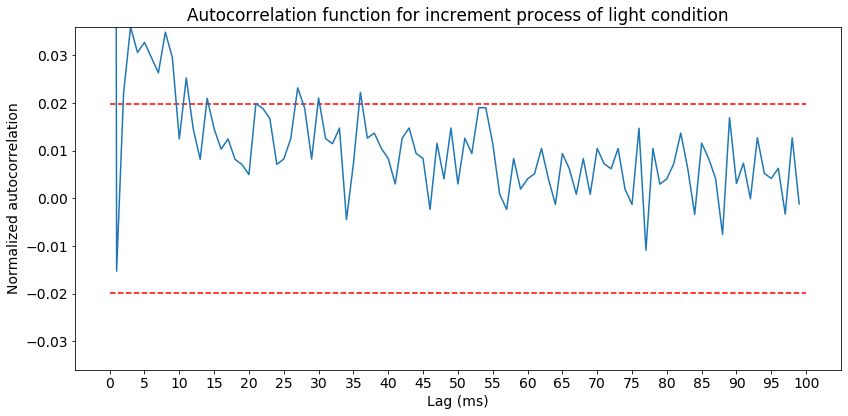

In [24]:
## Compute the autocorrelation for the increment process at 1 ms bins for the light condition for 
## 100 lags

# Set binwidth and lags.
binwidth = 0.001
lags = 100

# Compute autocorrelation, standard error, and 95% confidence interval.
ac_light = autocorr_inc(ts_light, binwidth, lags)
N = ac_light.size
std_err_light = np.std(ac_light) / np.sqrt(N)
ci_light = np.array([-2*std_err_light, 2*std_err_light])

# Compute absolute max value of autocorrelation for plotting purposes.
abs_max = np.max(np.abs(ac_light[1:]))

# Plot autocorelation and confidence interval bounds
fig7, ax7 = plt.subplots()
ax7.plot(ac_light)
ax7.hlines(ci_light[0], 0, ac_light.size, colors='r', linestyles='--')
ax7.hlines(ci_light[1], 0, ac_light.size, colors='r', linestyles='--')
ax7.set_ylim([-abs_max, abs_max])
ax7.set_xticks(np.arange(0,101,5))
ax7.set_title('Autocorrelation function for increment process of light condition')
ax7.set_ylabel('Normalized autocorrelation')
ax7.set_xlabel('Lag (ms)')

One notable characteristic is the negative correlation structure at ~ 2 ms. This most likely reflects the refractory period of the neuron: if a spike occurred in the previous 2 ms, one is less likely to occur in the next few milliseconds. The significant positive correlation from ~ 4-12 ms may reflect bursting phenomena displayed by this neuron. Beyond this point, the values of the autocorrelation mostly remain between the two significance bounds.

*Alert!* The confidence intervals here are used for exploratory purposes. We are not performing a rigorous statistical test for significance of the autocorrelation at every lag. To perform a rigorous statistical test, we should ideally have many more samples (i.e. many more recorded spike trains under both conditions). Additionally, we would have to correct for the *multiple comparisons problem*. Briefly, if we perform many independent tests, and each has a 5% chance of reaching significance by chance, then the probability that any of these tests reaches significance by chance can be very large. If we wanted to perform many tests, we would need to control for multiple comparisons by adjusting the significance level so that the probability of any test being significant by chance is small. In the plot above, the significance lines are not corrected for multiple comparisons. Therefore, we accept that some of the correlation values that exceed these bounds may occur by chance. However, it is still very unlikely that the significant correlations we observed from  4 to 12 ms are occurring purely by chance.

<div class="question">

**Q:** How can we control for multiple comparisons in our above exploratory analysis in order to perform a more confirmatory analysis and declare the autocorrelation values at certain lags truly significant? (Note that this is a toy example, because we only have one sample in each conidition, and ideally we'd want many more before performing this type of hypothesis testing/model comparison).
    
We can use *family-wise error rate* (FWER) and *false discovery rate* (FDR) corrections to adjust the $\alpha$ significance levels for each lag value (i.e. for each comparison) in order to reduce the probability of having a false positive by chance. Use the Holm-Bonferonni FWER correction and the Benjamini-Hochberg FDR correction to see if the autocorrelation value at each lag is significant. Use $\alpha = 0.05$

(*Hint*: First compute the uncorrected p-values for each ac value using `scipy.stats.norm.cdf`, then correct for multiple comparisons using `statsmodels.stats.multitest.multipletests`)
    
</div>

In [25]:
## Run significance testing on multiple comparison corrected p-values
## for the autocorrelation values of the increment process of the light
## condition from 1:100 ms with bins of 1 ms.

# compute p-values using 2-sided t-test for each ac value
m = len(ac_light)  # number of comparisons
p = np.zeros((m,))
for i, ac in enumerate(ac_light):
    p[i] = 1 - stats.norm.cdf(ac, loc=0, scale=std_err_light)
    
# test for significance against holm-bonferonni FWER correction
hb_reject, hb_p_corrected = multipletests(p, alpha=0.05, method='holm')[0:2]

# test for significance against benjamini-hochberg FDR correction
bh_reject, bh_p_corrected = multipletests(p, alpha=0.05, method='fdr_bh')[0:2]

# find lag values for which we reject the null
hb_reject_lags = np.where(hb_reject)[0]
bh_reject_lags = np.where(bh_reject)[0]
print(f'The ac values at the following lags were deemed significant for the '
      f'H-B FWER correction: {hb_reject_lags}')
print(f'The ac values at the following lags were deemed significant for the '
      f'B-H FDR correction: {bh_reject_lags}')

The ac values at the following lags were deemed significant for the H-B FWER correction: [0 3 5 8]
The ac values at the following lags were deemed significant for the B-H FDR correction: [0 3 4 5 6 7 8 9]


After correcting for multiple comparisons, we see that with the stricter, less powerful H-B FWER correction, the ac of the increment process for the light condition at lags of 3, 5, and 8 ms is significantly greater than normal, meaning we are more likely to see spikes at these time periods after an initial spike than at any other time period after an initial spike.

For the less strict, more powerful B-H FDR correction, the ac of the increment process for the light condition at lags of 3-9 ms is significantly greater than normal.

<div class="question">

**Q:** We just saw how the autocorrelation of the increment process can reveal certain phenomena (e.g. a refractory period and bursting) of a single spike train, but how can we compare temporal dependency between spike trains? 

Compute the difference between the light and dark condition autocorrelation functions at every lag for 100 lags from the increment processes computed from a 1 ms binwidth. If we assume that the firing in each condition is independent, the significance bounds for this difference can be computed by taking the square root of the combined variance of the autocorrelation from each condition (the two sample standard error). As above, plot the autocorrelation values and the 95% confidence interval bounds as dashed red horizonal lines around the mean. Set the ylim of the axes to be the negative and positive absolute maximum value of the autocorrelation, set x ticks for every 5 ms from 0 to 100 ms, and appropriately label the axes.

(*Hints*: First compute the autocorrelation function (and its standard error) for the dark condition for 100 lags from the increment process computed from a 1 ms binwidth. Then compute the diff autocorrelation and its standard error. Then create the figure.)
    
</div>

Text(0.5, 0, 'Lag')

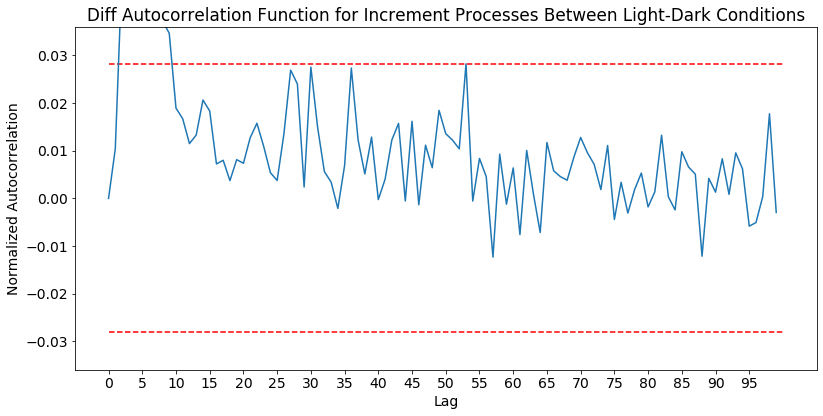

In [26]:
## Compute the difference between the light and dark condition 
## autocorrelation functions (i.e. the increment processes computed at a
## 1 ms binwidth) at every lag for 100 lags, and plot this difference 
## along with 95% c.i. bars

# compute `ac_dark`
binwidth = 0.001
lags = 100
ac_dark = autocorr_inc(ts_dark, binwidth, lags)
N = ac_dark.size
std_err_dark = np.std(ac_dark) / np.sqrt(N)

# compute difference between `ac_light` and `ac_dark`
ac_diff = ac_light - ac_dark
std_err_diff = np.sqrt(std_err_light**2 + std_err_dark**2)

ci_diff = np.array([-2*std_err_diff, 2*std_err_diff])
abs_max_diff = np.max(np.abs(ac_diff[1:]))
fig8, ax8 = plt.subplots()
ax8.plot(ac_diff)
ax8.hlines(ci_diff[0], 0, ac_diff.size, colors='r', linestyles='--')
ax8.hlines(ci_diff[1], 0, ac_diff.size, colors='r', linestyles='--')
ax8.set_ylim([-abs_max, abs_max])
ax8.set_xticks(np.arange(0,100,5))
ax8.set_title('Diff Autocorrelation Function for Increment Processes '
              'Between Light-Dark Conditions')
ax8.set_ylabel('Normalized Autocorrelation')
ax8.set_xlabel('Lag')

The results suggest significant differences in the autocorrelation between the two conditions at time lags of approximately 3–10 ms. These are roughly the same time lags we identified with bursting activity in the light condition. This suggests that the neuron fires with more intermediate ISIs in the bursting range in the light condition.

<div class="question">

**Q**: How can we control for multiple comparisons in our above exploratory analysis in order to perform a more confirmatory analysis and declare the diff autocorrelation values at certain lags truly significant? 
    
As done above for the light condition, similarly test this diff autocorrelation for significant deviations from normal (at $\alpha = 0.05$) by  correcting for multiple comparisons using H-B FWER and B-H FDR.

</div>

In [27]:
## Run significance testing on multiple comparison corrected p-values
## for the diff autocorrelation values from 1:100 ms with bins of 1 ms.

# compute p-values using 2-sided t-test for each ac value
m = len(ac_diff)  # number of comparisons
p = np.zeros((m,))
for i, ac in enumerate(ac_diff):
    p[i] = 1 - stats.norm.cdf(ac, loc=0, scale=std_err_diff)
    
# test for significance against holm-bonferonni FWER correction
hb_reject, hb_p_corrected = multipletests(p, alpha=0.05, method='holm')[0:2]

# test for significance against benjamini-hochberg FDR correction
bh_reject, bh_p_corrected = multipletests(p, alpha=0.05, method='fdr_bh')[0:2]

# find lag values for which we reject the null
hb_reject_lags = np.where(hb_reject)[0]
bh_reject_lags = np.where(bh_reject)[0]
print(f'The ac values at the following lags were deemed significant for the '
      f'H-B FWER correction: {hb_reject_lags}')
print(f'The ac values at the following lags were deemed significant for the '
      f'B-H FDR correction: {bh_reject_lags}')

The ac values at the following lags were deemed significant for the H-B FWER correction: [2 3 4 5]
The ac values at the following lags were deemed significant for the B-H FDR correction: [2 3 4 5 6 7]


After correcting for multiple comparisons, we see that with the stricter, less powerful H-B FWER correction, the diff ac at lags of 2-5 ms is significantly greater than normal, meaning we are more likely to see spikes at these time periods for the light condition than the dark condition.

For the less strict, more powerful B-H FDR correction, the diff at lags of 2-7 ms is significantly greater than normal.

<div class="question">

**Q**: Additionally, suppose we recorded a spike train for a third condition in medium light, `ts_medium`: how could we compare the temporal dependency between all three spike trains?
    
Create the `ts_medium` variable as an array with 800 random values between 0-30 s. Run an ANOVA test at $\alpha = 0.05$ (and if significant, compute the pairwise t-tests between each combination of groups, while correcting for multiple comparisons) on the autocorrelation values for the increment processes (computed at a binwidth of 1 ms) of the spike trains in all three conditions. Only use the autocorrelation values between 2-10 ms, since we've already seen that this area is where there is most likely to be differences between the conditions due to bursting.

*Hints*: Use `np.random.uniform` to create `ts_medium`. Use `...` to run the ANOVA, and `...` to compute the t-tests if the ANOVA yields a significant result.
</div>

In [29]:
## Compute a three-group ANOVA between the autocorrelations of the
## increment processes (calculated for 100 lags at binwidth = 1 ms) for
## the three different conditions, and if the result is significant 
## (at $/alpha = 0.05$) then compute the LSD.

# create the `ts_medium` variable and its ac
ts_medium = np.random.uniform(low=0, high=30, size=800)
binwidth = 0.001
lags = 100
ac_medium = autocorr_inc(ts_medium, binwidth, lags)

# compute the ANOVA (only use lags from)

# compute the LSD


*Alert!* After running the ANOVA test, we could have used Fisher's LSD to do the pairwise comparison across groups instead of the t-test, but beware that when using Fisher's LSD post-ANOVA you cannot correct for multiple comparisons, and Fisher's LSD restricts FWER to alpha only in the case of a <= three group comparison. 

We have now looked at different ways to perform hypothesis testing on our data in order to determine 1) if the ac value at any particular lag within a condition significantly deviates from normal, and 2) if the ac values at particular lags between conditions is significantly different. However, in the above examples, we only had one sample from each condition, which makes our analysis very weak. 

In practice, we should a priori determine at what significance value, power, and effect size we would consider a rejection of the null hypothesis to be meaningful, and use this to determine a minimum sample size for our study. This is called running *a priori power analysis*, and the equation for this is given below:

...

<div class="question">

**Q**: Suppose we would consider a rejection of the null hypothesis
meaningful at a significance level of $\alpha = 0.01$, power of 
$\beta = 0.99$, and effect size of $ES$ = 0.5. What should be the minimum number of samples, $n$, for each of our conditions?
    



</div>

<a id="ACsOfISIs"></a>
### Autocorrelations of the ISIs

The autocorrelation of the increments indicates the amount of time for which there are dependencies in the spiking data. In the light condition, we found large correlation values at certain time values. This could be a consequence of the influence of patterns of many spikes with shorter ISIs or of single spikes with longer ISIs. We can distinguish between these possibilities by looking at the autocorrelation of the sequence of ISIs. In this case, the lag represents the number of spikes in the past rather than the amount of time in the past. If the dependence is only due to the last spike, we expect the ISIs to be uncorrelated at any nonzero lag. This would necessarily be true for data from a Poisson process. If we see correlation between ISIs, this suggests that the data do not come from a Poisson process and that past spiking has an influence over future spikes.

<div class="question">

**Q:** How can we continue to look at the history dependence of a spike train using autocorrelation? Similarly to how we computed the autocorrelation for increment processes, compute the autocorrelation of the ISIs for the light condition for 100 lags (i.e. for up to 100 spikes). Add bounds for the 95% confidence interval of this autocorrelation. To compare temporal dependency between spike trains, compute the difference between the light and dark condition autocorrelation functions of the ISIs with 95% confidence interval bounds, and come up with a reasonable description that fits the data visualization.
    
**Note*: We've over-engineered our original autocorrelation function, `autocorr_inc`: this function actually performs two tasks: calculating the increment process, and then calculating the autocorrelation. For our current case, we don't want to compute an increment process first; our original function should have been separated into two functions to adhere to the "one task per function" policy. So, let's create a new function, `autocorr`, that *only* creates the autocorrelation of a timeseries vector from a given timeseries vector and a number of lags.
    
</div>

In [ ]:
def autocorr(x, lags):
    """ 
    Returns the autocorrelation at given lags for a given time series computed at a given 
    binwidth (in s).
    
    Parameters:
    -----------
        x (ndarray | list | tuple): a time-series data vector (in s)
        lags (int): The number of lags for which to return the autocorrelation of `x`
    
    Returns:
    --------
        ac (ndarray): The autocorrelation at of `x` at `lags` 
    """

    # Ensure `x` is ndarray.
    x = np.asarray(x)

    # Compute autocorrelation.
    x_norm = (x-x.mean())
    xc = np.correlate(x_norm, x_norm, 'full')
    xc_norm = xc / xc.max()
    
    # Reduce `xc` to values at positive lags only (since these will be identical to negative lags)
    # and return as `ac` at the specified `lags`
    ac = xc_norm[xc_norm.size//2:][:lags+1]

    return ac

In [ ]:
# Use and test `autocorr` function here.

In [ ]:
# Compute and visualize autocorrelation of the ISIs for the light condition here.

In [ ]:
# Compute and visualize the diff autocorrelation for the ISIs of the light-dark condition here.

If the autocorrelation function has high values at certain lags, this could suggest that data come from a renewal process, a spiking process with independent ISIs for which the probability of a spike at any time only depends on the time of the most recent spike.

[Back to top](#top)

<a id="summary"></a>
## Summary
In this chapter, we considered the spiking activity recorded in two conditions. We began with visualizations of the spiking data, and construction and visualization of the increment process (i.e., binned spike counts). We then assessed the variability in the increments through computation of the Fano factor, and became confident that spiking in the light condition displayed more variability than expected for a Poisson process. We also assessed the autocorrelation of the increment processes and observed the impact of refractoriness and bursting activity. In addition, we created and visualized the ISIs for each condition. Inspection of the ISI histograms suggested bursting activity in both conditions, and more small ISIs in the light condition. Analysis of the ISI autocorrelations revealed no compelling evidence for dependence and supported the hypothesis of a renewal process.

[Back to Top](#top)
<a id="appendix"></a>
## Appendix: Spike Count Mean and Variance for a Poisson Process

In this appendix, we compute the theoretical mean $\mu$ and the theoretical variance of the spike count $\sigma^2$ for a Poisson process. Let’s compute $\mu$ using a general formula that makes use of the probability $P(k)$ of observing $k$ spikes,
<a id="eq:15"></a>

$$
\mu = \sum_{k=1}^\infty k P(k).
$$

Replacing $P(k)$ with the expression for a Poisson distribution 
(<a href="#eq:6" class="thumb">eq.<span><img src="imgs/eq6.png"></span></a>)
, we find

$$
\begin{eqnarray}
\mu &=& \sum_{k=0}^\infty k\left(\frac{\lambda^k e^{-k}}{k!}\right) \\
&=& e^{-\lambda}\sum_{k=0}^\infty k\frac{\lambda^k}{k!}.
\end{eqnarray}
$$

To make progress, let's write out the terms in the summation,
<a id="eq:16"></a>

$$
\begin{eqnarray}
\mu &=& e^{-\lambda}
\left( 
0 + 
\frac{\lambda^1}{1!} + 
2\frac{\lambda^2}{2!} + 
3\frac{\lambda^3}{3!} + 
4\frac{\lambda^4}{4!} + 
\cdots 
\right) \\
&=& e^{-\lambda}\lambda
\left(
1 + 
\frac{\lambda^2}{2!} + 
\frac{\lambda^3}{3!} + 
\cdots 
\right) \\
&=& e^{-\lambda}\lambda(e^\lambda) \\
&=& \lambda,
\end{eqnarray}
$$

where we have used the fact that $e^x = 1 + \frac{x^2}{2!} + \frac{x^3}{3!} + \frac{x^4}{4!} + \cdots$. Notice that the mean spike count equals the rate parameter of the Poisson process.

To find the spike count variance for a Poisson process, we follow a similar procedure. In general, we compute the variance $\sigma^2$ of the spike count $k$ with probability distribution $P(k)$ as 
<a id="eq:17"></a>

$$
\sigma^2 = \sum_{k=0}^\infty k^2 P(k) - \left(\sum_{k=0}^\infty k P(k)\right) ^2.
$$

As in our computation of the mean spike count, we replace $P(k)$ with (<a href=#eq:6 class=thumb>eq.<span><img src=imgs/eq6.png></span></a>)
, the expression for a Poisson process. Notice that the second term is the square of the expression (<a href=#eq:15 class=thumb>eq.<span><img src=imgs/eq15.png></span></a>)
, and for a Poisson process we found $\mu = \lambda$. Therefore, let’s replace the second term in (<a href=#eq:17 class=thumb>eq.<span><img src=imgs/eq17.png></span></a>)
 with $\sigma^2$ and substitute for $P(k)$ in the first term of (<a href=#eq:17 class=thumb>eq.<span><img src=imgs/eq17.png></span></a>) to find
 
$$
\begin{eqnarray}
\sigma^2 &=&
\sum_{k=0}^\infty
k^2
\left(
\frac{\lambda^k e^{-\lambda}}{k!}
\right)
- \lambda^2
\\
&=&
e^{-\lambda}
\sum_{k=0}^\infty
k^2
\frac{\lambda^k}{k!} 
- \lambda^2.
\end{eqnarray}
$$

To make progress, we follow the same strategy and write out the terms in the summation,

$$
\begin{eqnarray}
\sigma^2
&=&
e^{-\lambda}
\left(
0 + 
\lambda +
2^2\frac{\lambda^2}{2!} + 
3^2\frac{\lambda^3}{3!} + 
4^2\frac{\lambda^4}{4!} + 
\cdots
\right) - 
\lambda^2
\\
&=&
\lambda e ^{-\lambda}
\left(
1 + 
2\lambda + 
\frac{3}{2}\lambda ^2 + 
\frac{4}{6}\lambda ^2 + 
\cdots
\right) - 
\lambda^2.
\end{eqnarray}
$$

Now, we divide this sum of terms into two pieces, a "nice term" (in the first brackets) and "leftovers" (in the second brackets):

$$
\sigma^2 = \lambda e^{-\lambda}
\left(
\left[
1 + 
\lambda + 
\frac{\lambda^2}{2!} + 
\frac{\lambda^3}{3!} + 
\cdots
\right] + 
\left[
\lambda + 
\frac{2\lambda^2}{2!} + 
\frac{3\lambda^3}{3!} + 
\cdots
\right] 
\right) - 
\lambda^2.
$$

We can simplify by recognizing that 
$\left[
1 + 
\lambda + 
\frac{\lambda^2}{2!} + 
\frac{\lambda^3}{3!} + 
\cdots
\right]
=
e^\lambda$.
Then
<a id="eq:18"></a>

$$
\begin{eqnarray}
\sigma^2
&=&
\lambda e^{-\lambda}
\left(
e^\lambda + 
\lambda
\left[
1 + 
\lambda + 
\frac{\lambda^1}{1!} + 
\frac{\lambda^2}{2!} + 
\cdots
\right] 
\right)-
\lambda^2 \\
&=&
\lambda e^{-\lambda}
\left(
e^\lambda + \lambda e^\lambda
\right)
-\lambda^2 \\
&=&
\lambda + \lambda^2 - \lambda^2 \\
&=&
\lambda,
\end{eqnarray}
$$

where again we've used the definition of $e^\lambda$. We conclude that the spike count variance for a Poisson precess equals the firing rate $\lambda$.

Combining these results for the mean spike count $\mu$ 
(<a href=#eq:16 class=thumb>eq.<span><img src=imgs/eq16.png></span></a>)
and the spike count variance
(<a href=#eq:18 class=thumb>eq.<span><img src=imgs/eq18.png></span></a>),
we conclude that for a Poisson process,

$$\mu = \sigma^2 = \lambda,$$

and therefore for a Poisson process, the Fano factor $\sigma^2/\mu=1$.

[Back to top](#top)

In [ ]:
from IPython.core.display import HTML
HTML('../../assets/custom/custom.css')
# NO CODE